### 作者：东哥起飞

### 本篇文章来源于[《100天成为风控专家》](https://app7hmmvkwr2019.h5.xiaoeknow.com/p/course/ecourse/course_2ZAoFMNREbOv3DutKsoIi9Vlfky) 策略新增的D类调优(2)：Python实操

In [7]:
import pandas as pd
import numpy as np
import scorecardpy as sc
from sklearn import tree
from sklearn.tree import _tree
from sklearn import metrics
import seaborn as sns
from matplotlib import pyplot as plt
import os, re, sys
%matplotlib inline
## 设置属性防止中文乱码
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings("ignore")

In [8]:
import sklearn as sk
import matplotlib as mpl
print('python:%s'%(sys.version))
print('sklearn:%s'%(sk.__version__))
print('pandas:%s'%(pd.__version__))
print('numpy:%s'%(np.__version__))
print('matplotlib:%s'%(mpl.__version__))
print('seaborn:%s'%(sns.__version__))
print('scorecardpy:%s'%(sc.__version__))

python:3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
sklearn:1.3.2
pandas:2.0.0
numpy:1.23.5
matplotlib:3.7.1
seaborn:0.12.2
scorecardpy:0.1.9.7


## 0. 样本数据

In [9]:
df = pd.read_excel('data_v4.xlsx')
df.shape

(50000, 7)

In [10]:
df.head()

,sample_id,sample_month,adr_stability_grade,ovd_order_cnt_6m_grade,positive_biz_cnt_1y_grade,risk_score,is_dlq_30d
0,1,201802,10,1,10,1,0.0
1,2,201804,10,1,7,2,0.0
2,3,201803,10,1,7,3,0.0
3,4,201802,10,1,9,3,0.0
4,5,201804,10,1,10,1,0.0


假设现有规则为：

- `positive_biz_cnt_1y_grade`：最近一年履约等级
- `adr_stability_grade`：地址稳定等级

通过第三方数据源接入的新变量为：

- `risk_score`：风险模型分数
- `ovd_order_cnt_6m_grade`：最近6个月逾期次数

## 1. 通过样本分析

In [11]:
# 筛选通过样本
df_tg = df.loc[df['is_dlq_30d'].isnull()==False].reset_index(drop=True)
print(df_tg.shape)
# 通过样本整体坏账率
ttbadrate = df_tg.is_dlq_30d.mean()
print('通过样本坏客户浓度:{}%'.format(round(ttbadrate*100,2)))

(47430, 7)
通过样本坏客户浓度:9.5%


In [12]:
# 类型修改（因为有空值需转换否则报错）
df_tg['is_dlq_30d'] = df_tg['is_dlq_30d'].astype(int)
# 去除非分析对象
var0 = df_tg.columns.difference(['sample_id','sample_month','risk_score','ovd_order_cnt_6m_grade']).tolist()

def bins_calc(df:pd.DataFrame, col_lst:list):
    """
    计算变量的iv和lift，及分箱下的统计
    """
    # scorecardpy变量分箱
    bins_info = sc.woebin(df[col_lst], y='is_dlq_30d', breaks_list={}, method='tree', stop_limit=0)

    # 计算分箱下的lift值（简易版口径：分箱区间坏账率/整体样本平均坏账率）
    for k,v in bins_info.items():
        v['lift'] = v['badprob']/ttbadrate
        bins_info[k] = v

    # 生成变量的评估指标表
    print('评估指标计算')
    rule_lift = pd.DataFrame(([k,v['total_iv'].max(),v['lift'].max()] for k,v in bins_info.items()), columns=['name','iv','lift']) \
                  .sort_values(by=['iv','lift'],ascending=[False,True])

    display(rule_lift)

    print('变量分箱展示')
    for col in rule_lift['name'].tolist():
        if col == 'is_dlq_30d':
            continue
        else:
            display(bins_info[col].style.bar(subset=['badprob'], color='lightgreen', width=80, height=80, align='left', vmin=0).highlight_max(subset=['lift'], color='red',axis=0))

In [13]:
bins_calc(df_tg, var0)

[INFO] creating woe binning ...
评估指标计算


,name,iv,lift
0,positive_biz_cnt_1y_grade,0.329925,1.986718
1,adr_stability_grade,0.290425,1.876375


变量分箱展示


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values,lift
0,positive_biz_cnt_1y_grade,"[-inf,3.0)",5636,0.118828,4572,1064,0.188786,0.795861,0.103112,0.329925,3.0,False,1.986718
1,positive_biz_cnt_1y_grade,"[3.0,4.0)",2690,0.056715,2233,457,0.169888,0.667358,0.032950,0.329925,4.0,False,1.787843
2,positive_biz_cnt_1y_grade,"[4.0,5.0)",3157,0.066561,2714,443,0.140323,0.441167,0.015468,0.329925,5.0,False,1.476708
3,positive_biz_cnt_1y_grade,"[5.0,7.0)",6978,0.147122,6167,811,0.116222,0.225076,0.008163,0.329925,7.0,False,1.223082
4,positive_biz_cnt_1y_grade,"[7.0,8.0)",3639,0.076724,3270,369,0.101401,0.072027,0.000410,0.329925,8.0,False,1.067112
5,positive_biz_cnt_1y_grade,"[8.0,9.0)",3844,0.081046,3552,292,0.075963,-0.244736,0.004397,0.329925,9.0,False,0.799402
6,positive_biz_cnt_1y_grade,"[9.0,10.0)",4734,0.099810,4486,248,0.052387,-0.641512,0.031747,0.329925,10.0,False,0.551301
7,positive_biz_cnt_1y_grade,"[10.0,inf)",16752,0.353194,15929,823,0.049128,-0.709164,0.133679,0.329925,inf,False,0.517010


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values,lift
0,adr_stability_grade,"[-inf,3.0)",5945,0.125343,4885,1060,0.178301,0.725876,0.088108,0.290425,3.0,False,1.876375
1,adr_stability_grade,"[3.0,4.0)",3415,0.072001,2879,536,0.156955,0.572712,0.029697,0.290425,4.0,False,1.651732
2,adr_stability_grade,"[4.0,5.0)",7948,0.167573,6978,970,0.122043,0.280555,0.014771,0.290425,5.0,False,1.284338
3,adr_stability_grade,"[5.0,6.0)",4187,0.088277,3778,409,0.097683,0.030541,0.000083,0.290425,6.0,False,1.027983
4,adr_stability_grade,"[6.0,7.0)",3690,0.077799,3371,319,0.086450,-0.103998,0.000807,0.290425,7.0,False,0.909766
5,adr_stability_grade,"[7.0,8.0)",6848,0.144381,6352,496,0.072430,-0.296173,0.011235,0.290425,8.0,False,0.762226
6,adr_stability_grade,"[8.0,9.0)",5551,0.117036,5242,309,0.055666,-0.577341,0.030926,0.290425,9.0,False,0.585805
7,adr_stability_grade,"[9.0,inf)",9846,0.207590,9438,408,0.041438,-0.887456,0.114798,0.290425,inf,False,0.436080


发现已有策略规则的lift未超过2，对于阈值的调整空间有限，需借助新的规则识别风险客群。

## 3. 测试新变量区分效果

假如我们现在接入了一家三方数据源的变量，并针对样本数据进行了回溯。

- `risk_score`：模型风险分数
- `ovd_order_cnt_6m_grade`：最近六个月逾期笔数等级

In [14]:
var1 = ['risk_score','ovd_order_cnt_6m_grade','is_dlq_30d']
bins_calc(df_tg, var1)

[INFO] creating woe binning ...
评估指标计算


,name,iv,lift
0,risk_score,2.414019,5.956588
1,ovd_order_cnt_6m_grade,1.077085,3.983946


变量分箱展示


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values,lift
0,risk_score,"[-inf,2.0)",10724,0.226102,10690,34,0.003170,-3.496927,0.844532,2.414019,2.0,False,0.033365
1,risk_score,"[2.0,3.0)",7337,0.154691,7244,93,0.012675,-2.101553,0.311309,2.414019,3.0,False,0.133392
2,risk_score,"[3.0,4.0)",8062,0.169977,7768,294,0.036467,-1.020412,0.118106,2.414019,4.0,False,0.383769
3,risk_score,"[4.0,5.0)",7658,0.161459,7169,489,0.063855,-0.431383,0.025245,2.414019,5.0,False,0.671984
4,risk_score,"[5.0,6.0)",7578,0.159772,6560,1018,0.134336,0.390625,0.028531,2.414019,6.0,False,1.413705
5,risk_score,"[6.0,7.0)",2822,0.059498,2082,740,0.262225,1.219342,0.141058,2.414019,7.0,False,2.759563
6,risk_score,"[7.0,inf)",3249,0.068501,1410,1839,0.566020,2.519408,0.945238,2.414019,inf,False,5.956588


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values,lift
0,ovd_order_cnt_6m_grade,"[-inf,2.0)",37057,0.781299,35465,1592,0.042961,-0.849779,0.401961,1.077085,2.0,False,0.452104
1,ovd_order_cnt_6m_grade,"[2.0,3.0)",4566,0.096268,3629,937,0.205212,0.899747,0.110986,1.077085,3.0,False,2.159580
2,ovd_order_cnt_6m_grade,"[3.0,4.0)",3007,0.063399,2089,918,0.305288,1.431533,0.221908,1.077085,4.0,False,3.212734
3,ovd_order_cnt_6m_grade,"[4.0,inf)",2800,0.059034,1740,1060,0.378571,1.758160,0.342229,1.077085,inf,False,3.983946


可以看到这三个变量的风险区分能力是非常强的，既符合单调性要求，评估指标lift和iv也都比较高。

## 3. 制定新增策略&效果测算

**这一步骤其实和策略开发是一样的，可设计单变量规则、二维交叉规则、和基于决策树生成的多维交叉规则（详细内容可回顾“策略开发篇”）**

### 3.1. 单变量规则

我们看到`risk_score`模型分数类的变量效果是极其强的，所以从3个测试的新变量中，我们将`risk_score`作为单变量规则的首选。

基于以上分箱结果，根据lift的大小，考虑设置`>=6`作为决策的阈值，即`risk_score>=6`时命中拒绝，否则未命中则通过。

**新增risk_score单变量规则后，统计通过率和逾期率的变化**

In [15]:
def ruleset_calc(df:pd.DataFrame, lst:list):
    """
    规则集计算分析函数
    """
    data = df.copy()
    # 创建规则命中变量，默认值为0
    for n in lst:
        data[str(n[0])+'_hit'] = 0
    
    # 循环所有规则，计算命中情况
    for m in lst:       
        cond = data.eval(m[1])
        data[str(m[0])+'_hit'] = data[str(m[0])+'_hit'].mask(cond, other=1)
            
    # 计算综合命中率
    rule_hit = [c for c in data.columns if '_hit' in c]
    data['hit_any'] = data[rule_hit].any(axis=1)
    print('########## 综合命中率 ###############')
    print('综合命中率为:{}%'.format(data['hit_any'].mean()*100))
    
    # 计算规则的单一和自然命中率
    data['hit_sum'] =  data[rule_hit].sum(axis=1)
    print('########## 规则命中数量分布 ##########')
    display(data['hit_sum'].value_counts(normalize=True))
    
    pure_hit_info = []
    for col in rule_hit:
        hit_rate = round(data[data[col]==1].shape[0]*100/data.shape[0],4)
        pure_hit_sum = data[(data[col]==1)&(data['hit_sum']==1)].shape[0]
        pure_hit_rate = round(pure_hit_sum*100/data.shape[0],4)
        if hit_rate == 0:
            hit_rate = 0.00001
        pure_hit_pct = round(pure_hit_rate*100/hit_rate,4)
        pure_hit_info.append((col, pure_hit_rate, hit_rate, pure_hit_pct))

    pure_hit_df = pd.DataFrame(pure_hit_info, columns=['rule','pure_hit_rate', 'hit_rate', 'pure_hit_pct'])
    pure_hit_df = pure_hit_df.sort_values(['pure_hit_rate','pure_hit_pct'],ascending=[False,False])
    print('########## 单一/自然命中率 ##########')
    display(pure_hit_df.style.background_gradient(cmap="Greens", subset=['pure_hit_rate','pure_hit_pct']))
    
    return data['hit_any'].mean(),data

**1）已有策略规则的命中率统计**

In [16]:
# 配置规则组(变量名，规则判断逻辑)
rule_set = []
# 已有规则
rule_set.append(('positive_biz_cnt_1y_grade','positive_biz_cnt_1y_grade < 2'))
rule_set.append(('adr_stability_grade','adr_stability_grade < 2'))

# 测算在通过样本上的综合命中率
all_hit_rate,df1 = ruleset_calc(df_tg,rule_set)

########## 综合命中率 ###############
综合命中率为:0.0%
########## 规则命中数量分布 ##########


hit_sum
0    1.0
Name: proportion, dtype: float64

########## 单一/自然命中率 ##########


,rule,pure_hit_rate,hit_rate,pure_hit_pct
0,positive_biz_cnt_1y_grade_hit,0.000000,0.000010,0.000000
1,adr_stability_grade_hit,0.000000,0.000010,0.000000


**2）新增risk_score变量规则后，命中率的情况**

In [17]:
# 配置规则组(变量名，规则判断逻辑)
rule_set = []
# 已有规则
rule_set.append(('positive_biz_cnt_1y_grade','positive_biz_cnt_1y_grade < 2'))
rule_set.append(('adr_stability_grade','adr_stability_grade < 2'))
# 新增risk_score规则
rule_set.append(('risk_score','risk_score > 5'))

# 测算在通过样本上的综合命中率
all_hit_rate,df2 = ruleset_calc(df_tg, rule_set)

########## 综合命中率 ###############
综合命中率为:12.79991566519081%
########## 规则命中数量分布 ##########


hit_sum
0    0.872001
1    0.127999
Name: proportion, dtype: float64

########## 单一/自然命中率 ##########


,rule,pure_hit_rate,hit_rate,pure_hit_pct
2,risk_score_hit,12.799900,12.799900,100.000000
0,positive_biz_cnt_1y_grade_hit,0.000000,0.000010,0.000000
1,adr_stability_grade_hit,0.000000,0.000010,0.000000


**3）逾期率&通过率的变化计算**

In [18]:
# 提取调整后未被命中的样本
df2_new = df2[df2['hit_sum']==0]
newttlbadrate = df2_new.is_dlq_30d.mean()
print('调整前样本坏浓度为:{}%'.format(round(ttbadrate,5)*100))
print('调整后样本坏浓度为:{}%'.format(round(newttlbadrate,5)*100))
print('样本坏浓度下降幅度:{}%'.format(round((ttbadrate-newttlbadrate)*100/ttbadrate,3)))

调整前样本坏浓度为:9.501999999999999%
调整后样本坏浓度为:4.662%
样本坏浓度下降幅度:50.943%


In [19]:
passing_rate_a = df_tg.shape[0]/df.shape[0]
passing_rate_b = df2_new.shape[0]/df.shape[0]
print('调整前通过率为:{}%'.format(round(passing_rate_a,5)*100))
print('调整后通过率为:{}%'.format(round(passing_rate_b,5)*100))
print('通过率下降幅度:{}%'.format(round((passing_rate_a-passing_rate_b)*100/passing_rate_a,3)))

调整前通过率为:94.86%
调整后通过率为:82.718%
通过率下降幅度:12.8%


我们观察到，新增了risk_score以后，逾期率降低的幅度非常大（因为抓坏的能力比较强，通过iv和lift值可以看出）；

但同时我们看到整体通过率直接降低94.86%-82.718%=12.142%。虽然降幅少于逾期率，但降低的绝对值比较大，这部分要评估业务上是否可以接受大幅度的变量（可能导致业务量减少）。

### 3.2. 二维交叉规则

如果业务上认为通过减少过多无法接受，可以尝试采取二维交叉组合的方式来尽量少的减少对通过的影响。

1）二维交叉组合的分析

新增`risk_score`和`ovd_order_cnt_6m_grade`两个变量

In [21]:
risk_ovd_cros = pd.crosstab(df_tg['risk_score'], df_tg['ovd_order_cnt_6m_grade'])
risk_ovd_sum = df_tg.pivot_table(index='risk_score',columns='ovd_order_cnt_6m_grade',values='is_dlq_30d', aggfunc='sum')

In [22]:
risk_ovd_cros

ovd_order_cnt_6m_grade,1,2,3,4,5
risk_score,,,,,
1,10167,359,119,51,28
2,6477,496,226,70,68
3,6754,691,348,142,127
4,6043,798,439,211,167
5,5201,1089,662,358,268
6,1482,512,420,217,191
7,556,292,328,187,161
8,377,329,465,290,264


In [23]:
risk_ovd_sum

ovd_order_cnt_6m_grade,1,2,3,4,5
risk_score,,,,,
1,29,3,1,0,1
2,54,20,13,4,2
3,159,54,35,25,21
4,259,99,67,40,24
5,422,227,172,109,88
6,268,175,144,79,74
7,188,137,165,93,91
8,213,222,321,204,205


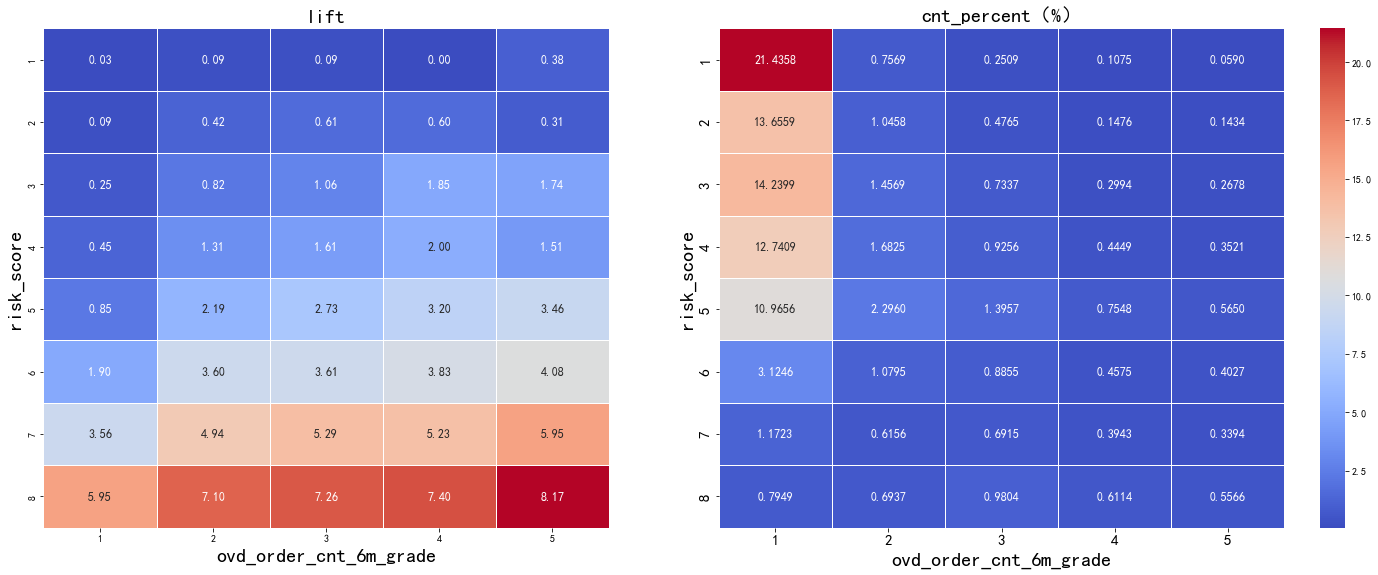

In [24]:
# 区间坏账率
cross_badrate = risk_ovd_sum/risk_ovd_cros
cross_pct     = risk_ovd_cros*100/df_tg.shape[0]
# 可视化
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
# sns.heatmap(cross_badrate, cmap='coolwarm', annot=True, fmt='.2f', linewidths=.5, annot_kws={'size':12}) 
# plt.xticks(size = 15) # 刻度
# plt.yticks(size = 15)
# plt.xlabel('ovd_order_cnt_6m_grade', fontdict={'size':20}, labelpad=5) #labelpad为标题距离刻度线范围
# plt.ylabel('risk_score', fontdict={'size':20}, labelpad=5)
# plt.title('badrate', fontdict={'size':20})
sns.heatmap(cross_badrate/ttbadrate, cmap='coolwarm', annot=True, fmt='.2f', linewidths=.5, annot_kws={'size':12}) 
plt.xlabel('ovd_order_cnt_6m_grade', fontdict={'size':20}, labelpad=5) #labelpad为标题距离刻度线范围
plt.ylabel('risk_score', fontdict={'size':20}, labelpad=5)
plt.title('lift', fontdict={'size':20})
plt.tight_layout()

plt.subplot(1, 2, 2)
sns.heatmap(cross_pct, cmap='coolwarm', annot=True, fmt='.4f', linewidths=.5, annot_kws={'size':12}) 
plt.xticks(size = 15) # 刻度
plt.yticks(size = 15)
plt.xlabel('ovd_order_cnt_6m_grade', fontdict={'size':20}, labelpad=5) #labelpad为标题距离刻度线范围
plt.ylabel('risk_score', fontdict={'size':20}, labelpad=5)
plt.title('cnt_percent（%）', fontdict={'size':20})
plt.show()

以上两个图，**左侧为lift值的交叉格子图（代表逾期率），右侧为样本数量占比的格子图（代表通过率）。**

这两个变量之间是互有补充的，可以根据以上格子中具体的值来挑选适合的拒绝对象。**选择lift非常高，且数量占比不高的格子**

2）执行二维交叉规则

In [26]:
# 配置规则组(变量名，规则判断逻辑)
rule_set = []
# 已有规则
rule_set.append(('positive_biz_cnt_1y_grade','positive_biz_cnt_1y_grade < 2'))
rule_set.append(('adr_stability_grade','adr_stability_grade < 2'))
# 新增risk_score规则
rule_set.append(('risk_positive_0','(risk_score >= 7) & (positive_biz_cnt_1y_grade >= 2)'))
rule_set.append(('risk_positive_1','(risk_score == 8) & (positive_biz_cnt_1y_grade == 1)'))
rule_set.append(('risk_positive_2','(risk_score == 6) & (positive_biz_cnt_1y_grade == 5)'))
# 测算在通过样本上的综合命中率
all_hit_rate,df3 = ruleset_calc(df_tg, rule_set)

########## 综合命中率 ###############
综合命中率为:7.556398903647481%
########## 规则命中数量分布 ##########


hit_sum
0    0.924436
1    0.075564
Name: proportion, dtype: float64

########## 单一/自然命中率 ##########


,rule,pure_hit_rate,hit_rate,pure_hit_pct
2,risk_positive_0_hit,6.850100,6.850100,100.000000
4,risk_positive_2_hit,0.706300,0.706300,100.000000
0,positive_biz_cnt_1y_grade_hit,0.000000,0.000010,0.000000
1,adr_stability_grade_hit,0.000000,0.000010,0.000000
3,risk_positive_1_hit,0.000000,0.000010,0.000000


3）效果测算

In [27]:
# 提取调整后未被命中的样本
df3_new = df3[df3['hit_sum']==0]
newttlbadrate = df3_new.is_dlq_30d.mean()
print('调整前样本坏浓度为:{}%'.format(round(ttbadrate,5)*100))
print('调整后样本坏浓度为:{}%'.format(round(newttlbadrate,5)*100))
print('样本坏浓度下降幅度:{}%'.format(round((ttbadrate-newttlbadrate)*100/ttbadrate,3)))

调整前样本坏浓度为:9.501999999999999%
调整后样本坏浓度为:5.923%
样本坏浓度下降幅度:37.669%


In [28]:
passing_rate_a = df_tg.shape[0]/df.shape[0]
passing_rate_b = df3_new.shape[0]/df.shape[0]
print('调整前通过率为:{}%'.format(round(passing_rate_a,5)*100))
print('调整后通过率为:{}%'.format(round(passing_rate_b,5)*100))
print('通过率下降幅度:{}%'.format(round((passing_rate_a-passing_rate_b)*100/passing_rate_a,3)))

调整前通过率为:94.86%
调整后通过率为:87.69200000000001%
通过率下降幅度:7.556%


以上结果发现，逾期率降幅也比较大，且区间的坏客户浓度更高，同时通过率的绝对值降低较为缓和，从risk_score单规则的12.8%下降到了7.56%。

以上的选择比较灵活，可以多尝试一些组合，放开或者收紧适合的“格子”，然后测算通过率和逾期率的效果，再进行评估。

## 番外

如果对pandas不熟悉想要进阶的朋友可以了解下东哥的这个原创笔记，已经完全体，后续随着版本迭代会持续更新。

[《pandas进阶宝典》](https://app7hmmvkwr2019.h5.xiaoeknow.com/p/course/ecourse/course_2YD5u0x8FzrAIyM8soEuxnTkP9r)永久访问权限，500页图文笔记，近30万字，配套完整代码支持下载。

5大核心图文，具体包括：
- 《pandas快速入门》
- 《pandas进阶宝典》
- 《pandas实战项目》
- 《pandas进阶题库》
- 《Numpy速查手册》
- 《正则表达式手册》

感兴趣可以扫码了解，或者加我微信可以有折扣，加V：`Petery_1966`

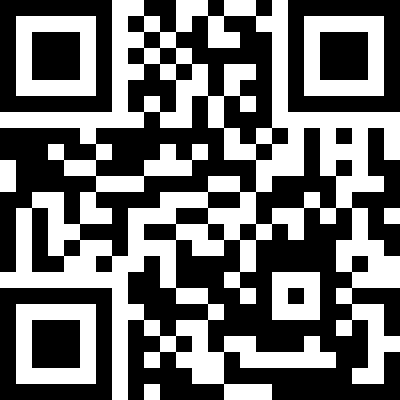